# Deteksi Penipuan Transaksi Online
Notebook ini menyajikan alur end-to-end berbahasa Indonesia: mulai dari mengunduh data langsung via gdown, membersihkan dan memadukan tabel transaksi serta identitas, menangani missing value dan class imbalance, melatih model tabular, melakukan tuning ringan, mengevaluasi kinerja, hingga menyiapkan berkas submission.

## 1. Import library
Mempersiapkan konfigurasi dasar seperti seed acak, direktori kerja, serta gaya visual.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import class_weight
import gdown

sns.set(style='whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

base_dir = Path.cwd()
data_dir = base_dir / 'data'
data_dir.mkdir(exist_ok=True, parents=True)
print('Working dir:', base_dir)

Working dir: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1


## 2. Unduh Data dari Google Drive dengan gdown


In [3]:
folder_url = 'https://drive.google.com/drive/folders/1JvI5xhPfN3VmjpWYZk9fCHG41xG697um'
print('Mengunduh data ke:', data_dir)
downloaded = gdown.download_folder(url=folder_url, output=str(data_dir), quiet=False, use_cookies=False)
print('Selesai unduh. File:')
for p in data_dir.glob('**/*'):
    if p.is_file():
        print('-', p.relative_to(base_dir))

Mengunduh data ke: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1\data


Retrieving folder contents


Processing file 1ALveidCmKzk4p_liQ7b663BXL0PcTaFN test_transaction.csv
Processing file 1Ujh37a1kTarNf3dSOSrj-hKDswULebYA train_transaction.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1ALveidCmKzk4p_liQ7b663BXL0PcTaFN
From (redirected): https://drive.google.com/uc?id=1ALveidCmKzk4p_liQ7b663BXL0PcTaFN&confirm=t&uuid=45a507f6-bd3d-48fa-8455-b252eb23f24c
To: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1\data\test_transaction.csv
100%|██████████| 613M/613M [01:30<00:00, 6.77MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1Ujh37a1kTarNf3dSOSrj-hKDswULebYA
From (redirected): https://drive.google.com/uc?id=1Ujh37a1kTarNf3dSOSrj-hKDswULebYA&confirm=t&uuid=34d3a99d-fbc1-4da6-8b8f-7193502911f3
To: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1\data\train_transaction.csv
100%|██████████| 683M/683M [01:53<00:00, 6.01MB/s] 

Selesai unduh. File:
- data\test_transaction.csv
- data\train_transaction.csv



Download completed


## 3. Muat dan Gabungkan Data
Membaca train/test transaksi dan, bila ada, pasangan identity. Keduanya digabung melalui TransactionID agar fitur identitas ikut dipakai saat pelatihan dan inferensi.

In [4]:
def load_csv(path_str):
    path = Path(path_str)
    return pd.read_csv(path) if path.exists() else None

train_transaction = load_csv(data_dir / 'train_transaction.csv')
train_identity = load_csv(data_dir / 'train_identity.csv')
test_transaction = load_csv(data_dir / 'test_transaction.csv')
test_identity = load_csv(data_dir / 'test_identity.csv')

if train_transaction is None or test_transaction is None:
    raise FileNotFoundError('train_transaction.csv atau test_transaction.csv tidak ditemukan di folder unduhan.')

def merge_tx_id(tx_df, id_df):
    return tx_df if id_df is None else tx_df.merge(id_df, on='TransactionID', how='left')

train_df = merge_tx_id(train_transaction, train_identity)
test_df = merge_tx_id(test_transaction, test_identity)

print('Train shape:', train_df.shape)
print('Test shape :', test_df.shape)
print('Kolom target ada:', 'isFraud' in train_df.columns)
train_df.head()

Train shape: (590540, 394)
Test shape : (506691, 393)
Kolom target ada: True


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Eksplorasi Ringkas
Meninjau distribusi label isFraud untuk melihat ketidakseimbangan dan menghitung rasio missing per kolom guna memahami seberapa besar pembersihan yang dibutuhkan.

Jumlah fraud: 20663
Proporsi fraud: 0.03499000914417313


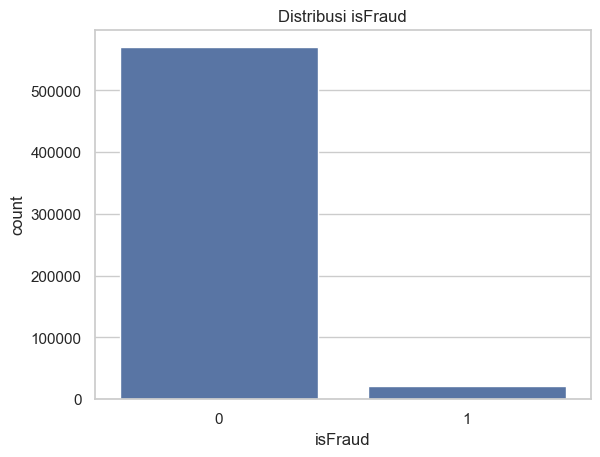

Kolom dengan missing tertinggi:
dist2    0.936284
D7       0.934099
D13      0.895093
D14      0.894695
D12      0.890410
D6       0.876068
D9       0.873123
D8       0.873123
V153     0.861237
V149     0.861237
dtype: float64


In [5]:
target = train_df['isFraud']
print('Jumlah fraud:', target.sum())
print('Proporsi fraud:', target.mean())
sns.countplot(x=target)
plt.title('Distribusi isFraud')
plt.show()

missing_ratio = train_df.isnull().mean().sort_values(ascending=False)
print('Kolom dengan missing tertinggi:')
print(missing_ratio.head(10))

## 5. Pra-pemrosesan dan Rekayasa Fitur Minimal
Langkah pembersihan inti: buang kolom dengan missing lebih dari 80%, pisahkan kolom numerik dan kategorikal, imputasi median/modus, lalu label-encode kategori. TransactionID disimpan hanya untuk pembuatan submission.

In [6]:
id_test = test_df['TransactionID'].copy()
X = train_df.drop(columns=['isFraud'])
y = train_df['isFraud']

full = pd.concat([X, test_df], axis=0, ignore_index=True)

threshold = 0.8
high_missing = [c for c in full.columns if full[c].isnull().mean() > threshold]
full = full.drop(columns=high_missing)
print('Kolom dibuang karena missing > 80%:', len(high_missing))

id_col = 'TransactionID'
id_series = full[id_col]
full = full.drop(columns=[id_col])

num_cols = full.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = [c for c in full.columns if c not in num_cols]

for c in num_cols:
    median_val = full[c].median()
    full[c] = full[c].fillna(median_val)

for c in cat_cols:
    mode_val = full[c].mode(dropna=True)
    mode_val = mode_val.iloc[0] if not mode_val.empty else 'missing'
    full[c] = full[c].fillna(mode_val)
    le = LabelEncoder()
    full[c] = le.fit_transform(full[c].astype(str))

full[id_col] = id_series.values

X_processed = full.iloc[:len(X)].copy()
test_processed = full.iloc[len(X):].copy()

X_processed = X_processed.drop(columns=[id_col])
test_processed = test_processed.drop(columns=[id_col])

print('Fitur akhir:', X_processed.shape[1])

Kolom dibuang karena missing > 80%: 55
Fitur akhir: 337


## 6. Split Data & Penanganan Ketidakseimbangan
Melakukan stratified train/validation split agar proporsi fraud terjaga, lalu menghitung class weight untuk mengimbangi kelas minoritas saat pelatihan.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

class_weights = class_weight.compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
sample_weight_train = y_train.map(class_weight_dict)
print('Bobot kelas:', class_weight_dict)
print('Split shape:', X_train.shape, X_val.shape)

Bobot kelas: {0: np.float64(0.5181288961224123), 1: np.float64(14.290139140955837)}
Split shape: (472432, 337) (118108, 337)


## 7. Model Baseline: HistGradientBoostingClassifier
Memulai dengan model gradien tree yang efisien untuk data tabular. Dilatih memakai bobot kelas, lalu dievaluasi dengan ROC-AUC, PR-AUC, classification report, dan confusion matrix.

ROC-AUC: 0.9361572186309912
PR-AUC : 0.6344385388307259
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    113975
           1       0.23      0.82      0.36      4133

    accuracy                           0.90    118108
   macro avg       0.61      0.86      0.65    118108
weighted avg       0.97      0.90      0.92    118108



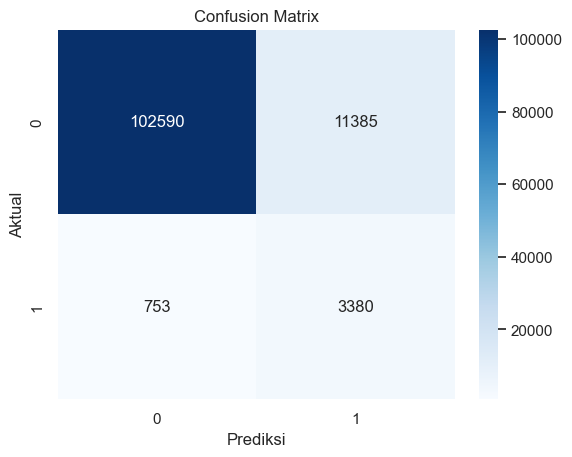

In [8]:
baseline_model = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=10,
    max_iter=150,
    random_state=RANDOM_STATE
)
baseline_model.fit(X_train, y_train, sample_weight=sample_weight_train)

val_proba = baseline_model.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)
roc = roc_auc_score(y_val, val_proba)
pr_auc = average_precision_score(y_val, val_proba)
print('ROC-AUC:', roc)
print('PR-AUC :', pr_auc)
print(classification_report(y_val, val_pred))
cm = confusion_matrix(y_val, val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

## 8. Tuning Sederhana (RandomizedSearchCV pada subset)
Melakukan pencarian acak pada subset 30% data latih untuk menguji kombinasi hiperparameter kunci tanpa membebani waktu komputasi. Skor acuan memakai ROC-AUC.

In [9]:
subset_frac = 0.3
sub_idx = np.random.choice(X_train.index, size=int(len(X_train) * subset_frac), replace=False)
X_sub = X_train.loc[sub_idx]
y_sub = y_train.loc[sub_idx]
w_sub = y_sub.map(class_weight_dict)

param_dist = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [6, 10, 14],
    'max_iter': [120, 160, 200],
    'max_leaf_nodes': [None, 31, 63]
}

search = RandomizedSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    param_distributions=param_dist,
    n_iter=8,
    scoring='roc_auc',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
search.fit(X_sub, y_sub, sample_weight=w_sub)
print('Best params:', search.best_params_)
print('Best ROC-AUC CV:', search.best_score_)

Best params: {'max_leaf_nodes': None, 'max_iter': 160, 'max_depth': 6, 'learning_rate': 0.1}
Best ROC-AUC CV: 0.9108728817476027


## 9. Latih Model Akhir dan Evaluasi
Melatih ulang model dengan parameter terbaik (jika ada) memakai seluruh data latih yang telah diproses. Kinerja divalidasi kembali dengan ROC-AUC dan PR-AUC untuk memastikan peningkatan.

In [10]:
best_params = search.best_params_ if 'search' in locals() else {}
final_model = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    **best_params
)
final_model.fit(X_processed, y, sample_weight=y.map(class_weight_dict))

val_proba_final = final_model.predict_proba(X_val)[:, 1]
roc_final = roc_auc_score(y_val, val_proba_final)
pr_final = average_precision_score(y_val, val_proba_final)
print('ROC-AUC final:', roc_final)
print('PR-AUC final :', pr_final)

ROC-AUC final: 0.9508646157508935
PR-AUC final : 0.6838704060686648


## 10. Prediksi Data Test & Submission
Menghasilkan probabilitas fraud untuk setiap TransactionID pada data test dan menyimpannya sebagai submission.csv agar siap diunggah.

In [ ]:
test_proba = final_model.predict_proba(test_processed)[:, 1]
submission = pd.DataFrame({
    'TransactionID': id_test,
    'isFraud': test_proba
})

out_path = base_dir / 'submission.csv'
submission.to_csv(out_path, index=False)
print('Submission disimpan di', out_path)
submission.head()

Submission disimpan di c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 1\submission.csv


,TransactionID,isFraud
0,3663549,0.145305
1,3663550,0.101701
2,3663551,0.136666
3,3663552,0.049626
4,3663553,0.090326
